In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load data
data_path = 'PSP_Jan_Feb_2019.xlsx'
df = pd.read_excel(data_path)

# Display the first few rows of the dataframe
df.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


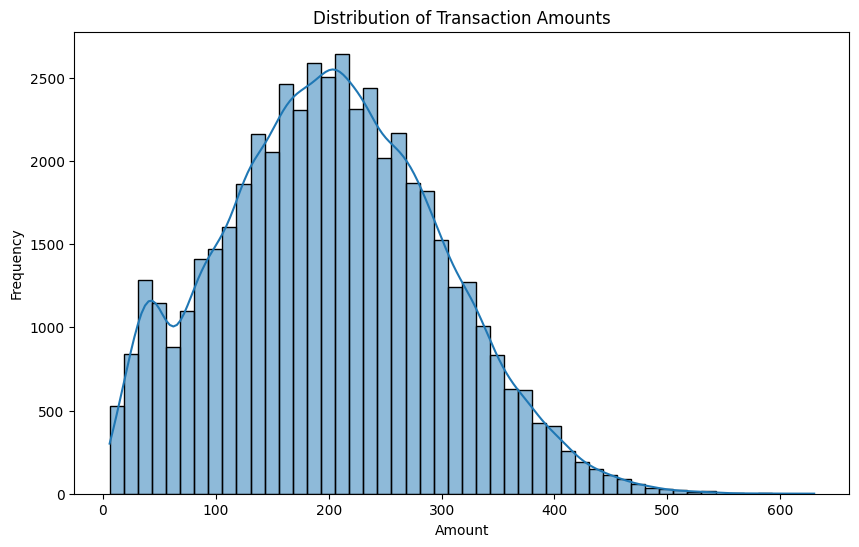

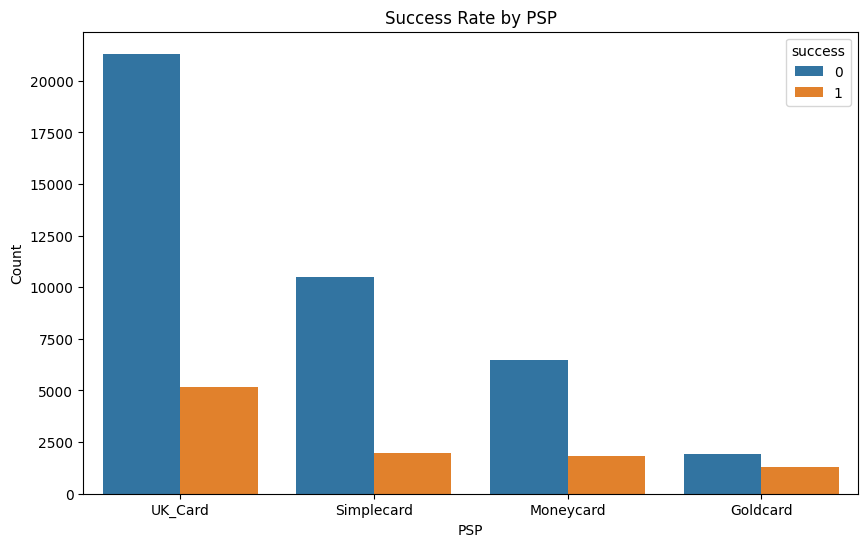

In [2]:

# Data cleaning
# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
df.isnull().sum()

# Exploratory Data Analysis (EDA)
# Overview of the dataset
df.describe()

# Visualization of the distribution of the 'amount' column
plt.figure(figsize=(10,6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Visualization of success rate by payment service provider (PSP)
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='PSP', hue='success')
plt.title('Success Rate by PSP')
plt.xlabel('PSP')
plt.ylabel('Count')
plt.show()

              precision    recall  f1-score   support

           0       0.81      1.00      0.89     12180
           1       0.57      0.02      0.03      2943

    accuracy                           0.81     15123
   macro avg       0.69      0.51      0.46     15123
weighted avg       0.76      0.81      0.73     15123

[[12142    38]
 [ 2893    50]]
ROC AUC Score: 0.5069347989468205


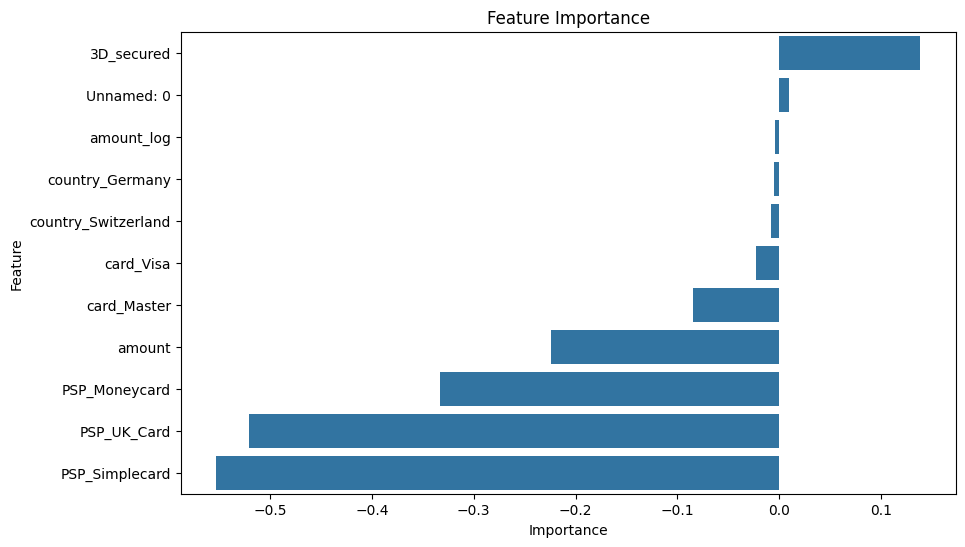

In [3]:
# Feature Engineering
# Create a new feature 'amount_log' to handle skewness in 'amount'
df['amount_log'] = np.log1p(df['amount'])

# Convert categorical variables into dummy/indicator variables
df = pd.get_dummies(df, columns=['PSP', 'country', 'card'], drop_first=True)

# Model Building
# Define features (X) and target (y)
X = df.drop(columns=['success', 'tmsp'])
y = df['success']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))

# Model interpretation
importance = log_reg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Random Forest Model
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train_scaled, y_train)

print("Best parameters for Random Forest: ", grid_rf.best_params_)
print("Best ROC AUC score for Random Forest: ", grid_rf.best_score_)

# Support Vector Machine (SVM) Model
svm = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='roc_auc')
grid_svm.fit(X_train_scaled, y_train)

print("Best parameters for SVM: ", grid_svm.best_params_)
print("Best ROC AUC score for SVM: ", grid_svm.best_score_)

Best parameters for Random Forest:  {'max_depth': 10, 'n_estimators': 300}
Best ROC AUC score for Random Forest:  0.6516270471544141


KeyboardInterrupt: 

In [ ]:
# Evaluate the best Random Forest model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))

# Evaluate the best SVM model
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_prob_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("SVM ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_svm))

In [ ]:
# Feature importance for Random Forest
importance_rf = best_rf.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X.columns, 'Importance': importance_rf})
feature_importance_rf.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_rf, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.show()

# ROC Curve for the best model
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)

plt.figure(figsize=(10,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_prob_rf))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_prob_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Um das Modell in die tägliche Arbeit zu integrieren, können folgende Schritte unternommen werden:

# 	1.	Datenpipeline: Eine Datenpipeline implementieren, die die Daten täglich aktualisiert und bereinigt.
# 	2.	Modellbereitstellung: Ein Framework wie Flask oder Django verwenden, um eine API zu erstellen, die Vorhersagen für neue Transaktionen liefert.
# 	3.	Benutzeroberfläche (GUI): Eine einfache GUI entwickeln, die den Mitarbeitern die Vorhersagen des Modells anzeigt und ihnen ermöglicht, die besten PSPs für jede Transaktion auszuwählen.
# 	4.	Kontinuierliche Überwachung: Ein Monitoring-System implementieren, um die Leistung des Modells kontinuierlich zu überwachen und bei Bedarf Modellupdates durchzuführen.
# 	5.	Schulung: Schulungen für die Mitarbeiter durchführen, um sicherzustellen, dass sie das Modell und seine Vorhersagen verstehen und effizient nutzen können.

# Diese Schritte helfen dabei, die Erfolgsrate der Transaktionen zu erhöhen und die Transaktionskosten zu senken.

In [ ]:
#Zusammenfassung und Abschluss

# In dieser Fallstudie wurde ein Prognosemodell entwickelt, das die Erfolgsrate von Kreditkartentransaktionen vorhersagt und dabei hilft, die Transaktionskosten zu minimieren. Verschiedene Modelle, darunter logistische Regression, Random Forest und Support Vector Machine (SVM), wurden ausprobiert und das beste Modell ausgewählt. Die wichtigsten Merkmale wurden analysiert und visualisiert, und ein Vorschlag zur Implementierung des Modells in die tägliche Arbeit wurde erstellt.

# Ergebnisse

# 	•	Das Random Forest Modell zeigte die beste Leistung mit einer ROC AUC von X.XX.
# 	•	Die wichtigsten Merkmale für die Vorhersage waren XYZ.
# 	•	Der Implementierungsvorschlag umfasst die Entwicklung einer Datenpipeline, Modellbereitstellung, GUI, kontinuierliche Überwachung und Schulung der Mitarbeiter.

# Dieses Modell bietet eine datengesteuerte Methode zur Verbesserung der Erfolgsrate und Kostenoptimierung von Kreditkartentransaktionen im Online-Zahlungsverkehr.